In [1]:
options(warn=-1)
library(tidyverse)
library(emdbook)
library(ramify)
library(gridExtra)
library(rjags)
library(coda)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


ERROR: Error in library(emdbook): there is no package called ‘emdbook’


# Exercise 1

• Ladislaus Josephovich Bortkiewicz was a Russian economist and statistician. He noted that the
Poisson distribution can be very useful in applied statistics when describing low-frequency events
in a large population. In a famous example he showed that the number of deaths by horse kick
among the Prussian army follows the Poisson distribution.


• Considering the following to sets of observations taken over a fixed large time interval in two different
corps:

y death soldiers 0 1 2 3 4 ≥ 5

n1 observations 109 65 22 3 1 0

n2 observations 144 91 32 11 2 0

In [5]:
obs = c(0, 1, 2, 3, 4, 5)
n1 = c(109, 65, 22, 3, 1, 0)
n2 = c(144, 91, 32, 11, 2, 0)

median = function(mu, post, dt){
    for (i in seq(1, length(mu))){
        int  = sum(post[1:i]*dt)
        if (int>0.4999){med=mu[i]
                    break
        }
    }
    return(med)
}

dt = 0.001

In [6]:
data1=c()
for (i in seq(1,length(obs)-1)){
    for (j in 1:n1[i]){
        data1 = c(data1, obs[i])
    }
}

data2=c()
for (i in seq(1,length(obs)-1)){
    for (j in 1:n2[i]){
        data2 = c(data2, obs[i])
    }
}

(a) assuming a uniform prior, compute and plot the posterior distribution for λ, the death rate over
the measurement time. Determine the posterior mean, median and variance, and compute the 95%
credibility interval.

In [7]:
prior.uniform = 1

lh.poisson = function(y, mu){
    lh = 1
    for (i in y){
        lh = lh*dpois(i, mu)
    }
    return(lh)
}

posterior.uniform= function(mu, y){prior.uniform*lh.poisson(y, mu)}

posterior.normalised = function(mu, data, post.prior, dt, x=-1){
    Z = sum(post.prior(mu, data)*dt)
    if (x<0){return (post.prior(mu, data)/Z)}
    else{return (post.prior(x, data)/Z)}
}

# y = data2
# Z = sum(posterior.uniform(mu, y)*dt)
mu = seq(0,10, dt)

#Compute the posterior and important quantities for the first corp
post.uniform1 = posterior.normalised(mu, data1, posterior.uniform, dt)

moment1.uniform1 = sum(post.uniform1*mu*dt)
moment2.uniform1 = sum((moment1.uniform1 - mu)^2 * post.uniform1*dt)

cred.int.uniform1 = ncredint(mu, post.uniform1,0.95)
median.uniform1 = median(mu, post.uniform1,dt)


#Compute the posterior and important quantities for the second corp
post.uniform2 = posterior.normalised(mu, data2, posterior.uniform, dt)

moment1.uniform2 = sum(post.uniform2*mu*dt)
moment2.uniform2 = sum((moment1.uniform2 - mu)^2 * post.uniform2*dt)

cred.int.uniform2 = ncredint(mu, post.uniform2,0.95)
median.uniform2 = median(mu, post.uniform2, dt)

mu95.1 = mu[mu>cred.int.uniform1[['lower']] & mu<cred.int.uniform1[['upper']]]
mu95.2 = mu[mu>cred.int.uniform2[['lower']] & mu<cred.int.uniform2[['upper']]]


uniform1 = c(median.uniform1, moment1.uniform1, moment2.uniform1, cred.int.uniform1[['lower']], cred.int.uniform1[['upper']])
uniform2 = c(median.uniform2, moment1.uniform2, moment2.uniform2, cred.int.uniform2[['lower']], cred.int.uniform2[['upper']])
df = data.frame(Uniform_first_regiment = uniform1, Uniform_second_regiment = uniform2,
          row.names=c('Median','First moment', 'Second moment', 'Lower limit (95% credibility)', 'Upper limit (95% credibility)'))
df

ERROR: Error in ncredint(mu, post.uniform1, 0.95): could not find function "ncredint"


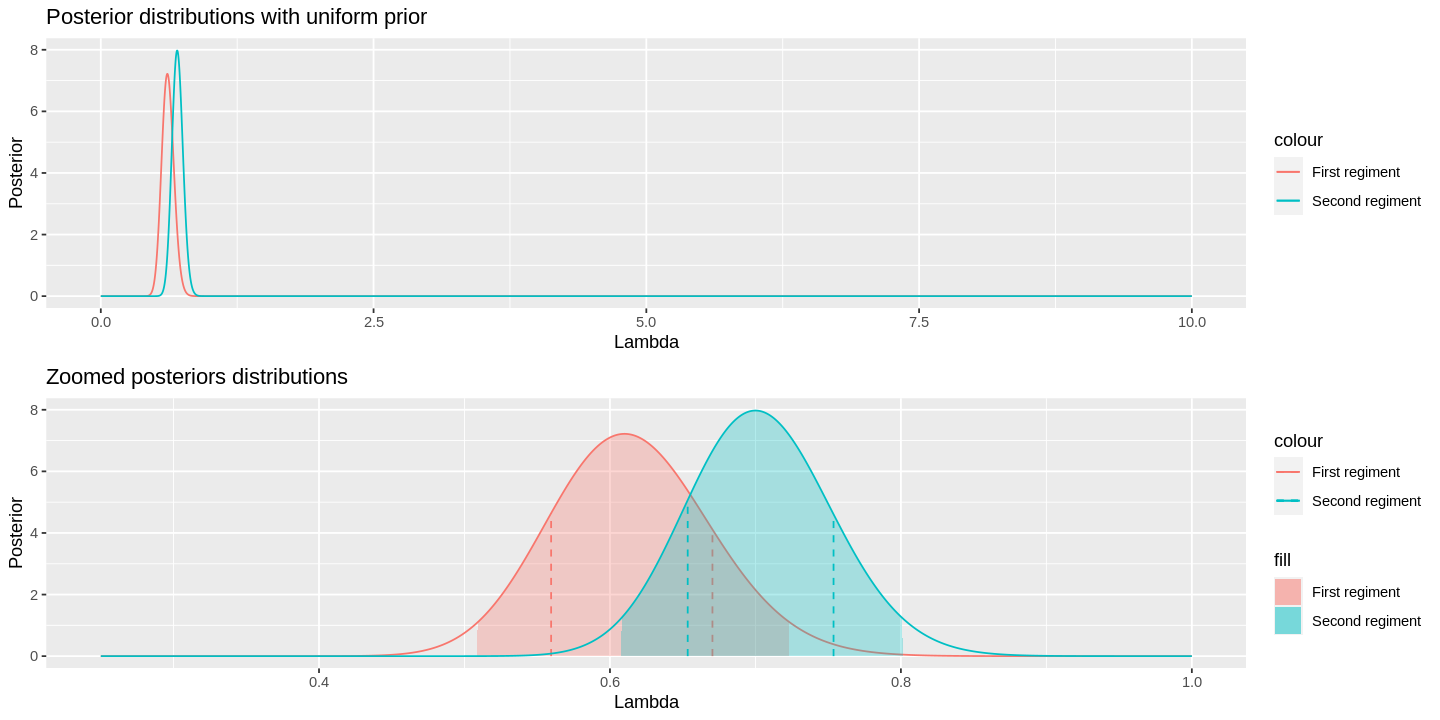

In [6]:
p1 = ggplot()+
geom_line(aes(x=mu, y=post.uniform1, color='First regiment'))+
geom_line(aes(x=mu, y=post.uniform2, color='Second regiment'))+
labs(x='Lambda', y='Posterior', title='Posterior distributions with uniform prior')


p2 = ggplot()+

geom_line(aes(x=mu, y=post.uniform1, color='First regiment'))+
geom_area(aes(x=mu95.1,
              y=post.uniform1[mu>cred.int.uniform1[1] & mu<cred.int.uniform1[2]],
              fill='First regiment'),alpha=0.3)+
geom_segment(aes(x=moment1.uniform1-sqrt(moment2.uniform1),
                 y=0,
                 xend=moment1.uniform1-sqrt(moment2.uniform1),
                 yend=posterior.normalised(mu, data1, posterior.uniform, dt, x=(moment1.uniform1-sqrt(moment2.uniform1))),
                 color='First regiment'),linetype='dashed')+
geom_segment(aes(x=moment1.uniform1+sqrt(moment2.uniform1),
                 y=0,
                 xend=moment1.uniform1+sqrt(moment2.uniform1),
                 yend=posterior.normalised(mu, data1, posterior.uniform, dt, x=(moment1.uniform1+sqrt(moment2.uniform1))),
                 color='First regiment'),linetype='dashed')+



geom_line(aes(x=mu, y=post.uniform2, color='Second regiment'))+
geom_area(aes(x=mu95.2,
              y=post.uniform2[mu>cred.int.uniform2[1] & mu<cred.int.uniform2[2]],
              fill='Second regiment'),alpha=0.3)+
geom_segment(aes(x=moment1.uniform2-sqrt(moment2.uniform2),
                 y=0,
                 xend=moment1.uniform2-sqrt(moment2.uniform2),
                 yend=posterior.normalised(mu, data2, posterior.uniform, dt, x=(moment1.uniform2-sqrt(moment2.uniform2))),
                 color='Second regiment'),linetype='dashed')+
geom_segment(aes(x=moment1.uniform2+sqrt(moment2.uniform2),
                 y=0,
                 xend=moment1.uniform2+sqrt(moment2.uniform2),
                 yend=posterior.normalised(mu, data2, posterior.uniform, dt, x=(moment1.uniform2+sqrt(moment2.uniform2))),
                 color='Second regiment'),linetype='dashed')+


xlim(0.25, 1)+
labs(x='Lambda', y='Posterior', title='Zoomed posteriors distributions')

options(repr.plot.width = 12, repr.plot.height=6)
grid.arrange(grobs=list(p1, p2), nrow=2)

(b) assuming now a Jeffreys’ prior, compute and plot the posterior distribution for λ, the death rate over the measurement time.
Determine the posterior mean, median and variance, and compute the 95% credibility interval

In [7]:
mu = seq(0.001,10, dt)
prior.jeffrey= function(mu){g<-1/sqrt(mu)}

lh.poisson = function(y, mu){
    lh = 1
    for (i in y){
        lh = lh*dpois(i, mu)
    }
    return(lh)
}

posterior.jeffrey= function(mu, y){prior.jeffrey(mu)*lh.poisson(y, mu)}

posterior.normalised = function(mu, data, post.prior, dt, x=-1){
    Z = sum(post.prior(mu, data)*dt)
    if (x<0){return (post.prior(mu, data)/Z)}
    else{return (post.prior(x, data)/Z)}
}

# y = data2
# Z = sum(posterior.uniform(mu, y)*dt)

#Compute the posterior and important quantities for the first corp
post.jeffrey1 = posterior.normalised(mu, data1, posterior.jeffrey, dt)

moment1.jeffrey1 = sum(post.jeffrey1*mu*dt)
moment2.jeffrey1 = sum((moment1.jeffrey1 - mu)^2 * post.jeffrey1*dt)

cred.int.jeffrey1 = ncredint(pvec=mu, npost=post.jeffrey1,level=0.95,tol=0.01,verbose=FALSE)
median.jeffrey1 = median(mu, post.jeffrey1,dt)


#Compute the posterior and important quantities for the second corp
post.jeffrey2 = posterior.normalised(mu, data2, posterior.jeffrey, dt)

moment1.jeffrey2 = sum(post.jeffrey2*mu*dt)
moment2.jeffrey2 = sum((moment1.jeffrey2 - mu)^2 * post.jeffrey2*dt)

cred.int.jeffrey2 = ncredint(pvec=mu, npost=post.jeffrey2,level=0.95,tol=0.01,verbose=FALSE)
median.jeffrey2 = median(mu, post.jeffrey2, dt)

mu95.1 = mu[mu>cred.int.jeffrey1[['lower']] & mu<cred.int.jeffrey1[['upper']]]
mu95.2 = mu[mu>cred.int.jeffrey2[['lower']] & mu<cred.int.jeffrey2[['upper']]]


jeffrey1 = c(median.jeffrey1, moment1.jeffrey1, moment2.jeffrey1, cred.int.jeffrey1[['lower']], cred.int.jeffrey1[['upper']])
jeffrey2 = c(median.jeffrey2, moment1.jeffrey2, moment2.jeffrey2, cred.int.jeffrey2[['lower']], cred.int.jeffrey2[['upper']])
df = data.frame(jeffrey_first_regiment = jeffrey1, jeffrey_second_regiment = jeffrey2,
          row.names=c('Median','First moment', 'Second moment', 'Lower limit (95% credibility)', 'Upper limit (95% credibility)'))
df

,jeffrey_first_regiment,jeffrey_second_regiment
,<dbl>,<dbl>
Median,0.6110000,0.701000000
First moment,0.6125000,0.701785714
Second moment,0.0030625,0.002506378
Lower limit (95% credibility),0.5060000,0.605000000
Upper limit (95% credibility),0.7210000,0.800000000


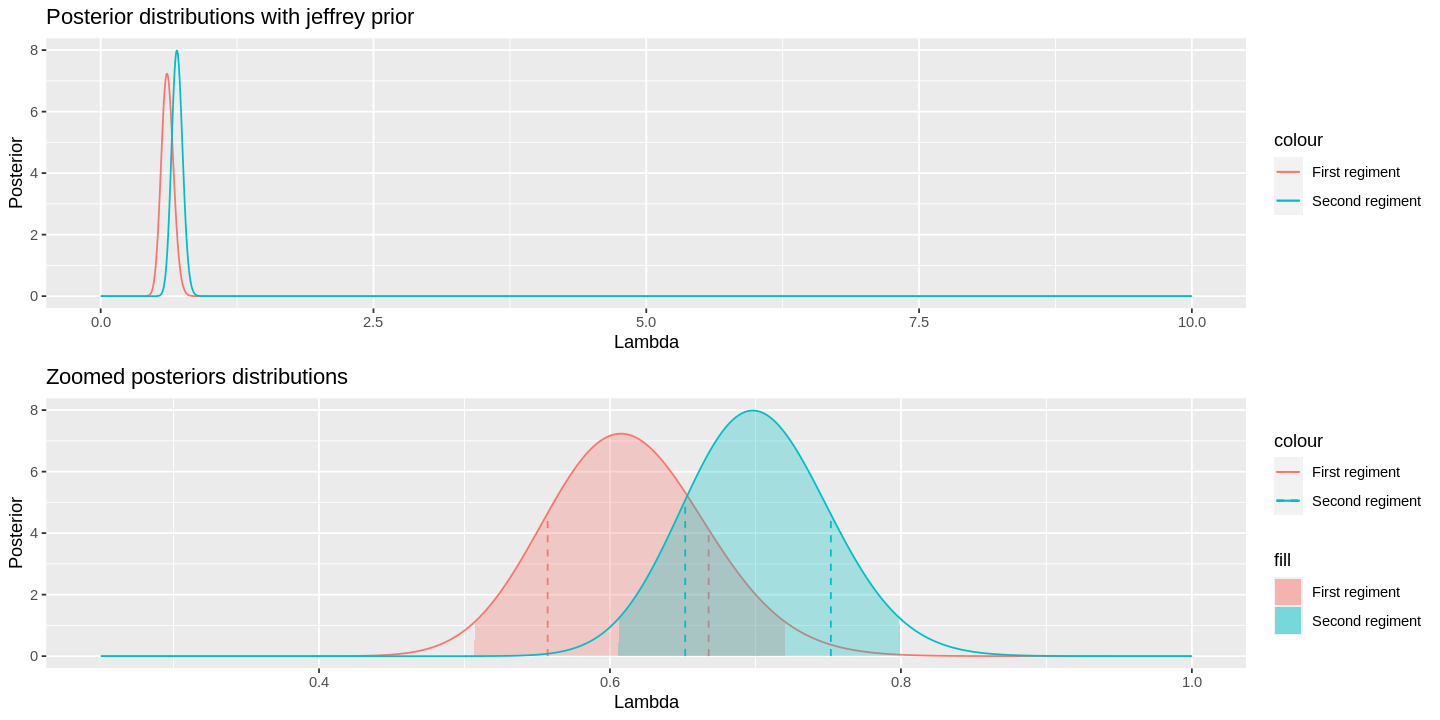

In [8]:
p1 = ggplot()+
geom_line(aes(x=mu, y=post.jeffrey1, color='First regiment'))+
geom_line(aes(x=mu, y=post.jeffrey2, color='Second regiment'))+
labs(x='Lambda', y='Posterior', title='Posterior distributions with jeffrey prior')


p2 = ggplot()+

geom_line(aes(x=mu, y=post.jeffrey1, color='First regiment'))+
geom_area(aes(x=mu95.1,
              y=post.jeffrey1[mu>cred.int.jeffrey1[['lower']] & mu<cred.int.jeffrey1[['upper']]],
              fill='First regiment'),alpha=0.3)+
geom_segment(aes(x=moment1.jeffrey1-sqrt(moment2.jeffrey1),
                 y=0,
                 xend=moment1.jeffrey1-sqrt(moment2.jeffrey1),
                 yend=posterior.normalised(mu, data1, posterior.jeffrey, dt, x=(moment1.jeffrey1-sqrt(moment2.jeffrey1))),
                 color='First regiment'),linetype='dashed')+
geom_segment(aes(x=moment1.jeffrey1+sqrt(moment2.jeffrey1),
                 y=0,
                 xend=moment1.jeffrey1+sqrt(moment2.jeffrey1),
                 yend=posterior.normalised(mu, data1, posterior.jeffrey, dt, x=(moment1.jeffrey1+sqrt(moment2.jeffrey1))),
                 color='First regiment'),linetype='dashed')+



geom_line(aes(x=mu, y=post.jeffrey2, color='Second regiment'))+
geom_area(aes(x=mu95.2,
              y=post.jeffrey2[mu>cred.int.jeffrey2[['lower']] & mu<cred.int.jeffrey2[['upper']]],
              fill='Second regiment'),alpha=0.3)+
geom_segment(aes(x=moment1.jeffrey2-sqrt(moment2.jeffrey2),
                 y=0,
                 xend=moment1.jeffrey2-sqrt(moment2.jeffrey2),
                 yend=posterior.normalised(mu, data2, posterior.jeffrey, dt, x=(moment1.jeffrey2-sqrt(moment2.jeffrey2))),
                 color='Second regiment'),linetype='dashed')+
geom_segment(aes(x=moment1.jeffrey2+sqrt(moment2.jeffrey2),
                 y=0,
                 xend=moment1.jeffrey2+sqrt(moment2.jeffrey2),
                 yend=posterior.normalised(mu, data2, posterior.jeffrey, dt, x=(moment1.jeffrey2+sqrt(moment2.jeffrey2))),
                 color='Second regiment'),linetype='dashed')+


xlim(0.25, 1)+
labs(x='Lambda', y='Posterior', title='Zoomed posteriors distributions')

options(repr.plot.width = 12, repr.plot.height=6)
grid.arrange(grobs=list(p1, p2), nrow=2)

# Exercise 2

• solve Exercise 1 with a Markov Chain Monte Carlo. Build your own MCMC, using the functions
introduced during lectures, or using a MCM library like JAGS.

In [8]:
obs = c(0, 1, 2, 3, 4, 5)
n1 = c(109, 65, 22, 3, 1, 0)
n2 = c(144, 91, 32, 11, 2, 0)



data1=c()
for (i in seq(1,length(obs)-1)){
    for (j in 1:n1[i]){
        data1 = c(data1, obs[i])
    }
}

data2=c()
for (i in seq(1,length(obs)-1)){
    for (j in 1:n2[i]){
        data2 = c(data2, obs[i])
    }
}

Data1 <- NULL
Data1$X <- data1 # Set of observations
Data1$n_next <- 10 # Predictions

Data2 <- NULL
Data2$X <- data2 # Set of observations
# data$n <- length(X) # those to be considered
Data2$n_next <- 10 # Predictions

In [9]:
model = 's11_inf_p_pred.bug'

In [10]:
jm1 <- jags.model(model , Data1)
jm2 <- jags.model(model , Data2)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 2
   Total graph size: 203

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 280
   Unobserved stochastic nodes: 2
   Total graph size: 283

Initializing model



In [11]:
cat('Chain for the First Regiment')
update(jm1 , 1000)
chain1 <- coda.samples (jm1 , c("lambda", "y"), n.iter=10000)
print( summary (chain1 ))


cat('\n \n Chain for the Second Regiment')
update(jm2 , 1000)
chain2 <- coda.samples (jm2 , c("lambda", "y"), n.iter=10000)
print( summary (chain2 ))

Chain for the First Regiment
Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean      SD  Naive SE Time-series SE
lambda 0.6161 0.05559 0.0005559      0.0005559
y      0.5960 0.77204 0.0077204      0.0077204

2. Quantiles for each variable:

        2.5%    25%    50%   75%  97.5%
lambda 0.513 0.5777 0.6139 0.652 0.7326
y      0.000 0.0000 0.0000 1.000 2.0000


 
 Chain for the Second Regiment
Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean      SD  Naive SE Time-series SE
lambda 0.7042 0.04978 0.0004978      0.0004978
y      0.6917 0.82844 0.0082844      0.0082844

2. Quantiles for each variable:

         2.5%    25%    50%    75%  97.5%
lambda 0.6111 0.6697 0.7032 


 Correlation matrix: 
          lambda         y
lambda 1.0000000 0.0721477
y      0.0721477 1.0000000


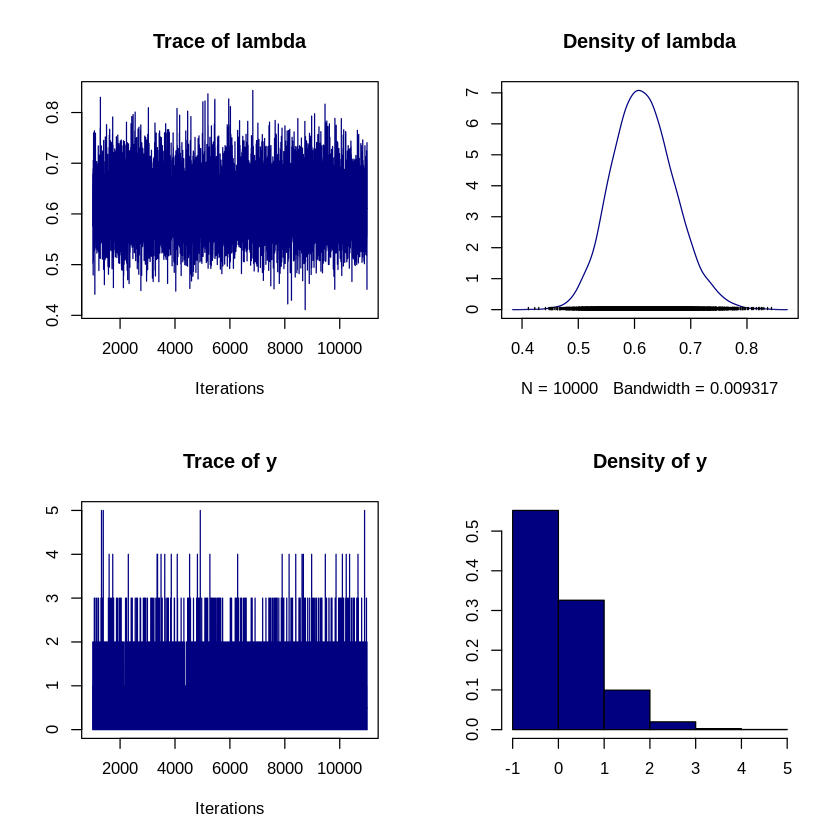

In [12]:
plot(chain1 , col="navy")
# Let ’s format our chain
chain1.df <- as.data.frame( as.mcmc(chain1) )
cat( sprintf ("\n Correlation matrix: \n"))
print(cor(chain1.df))


 Correlation matrix: 
           lambda          y
lambda 1.00000000 0.06941935
y      0.06941935 1.00000000


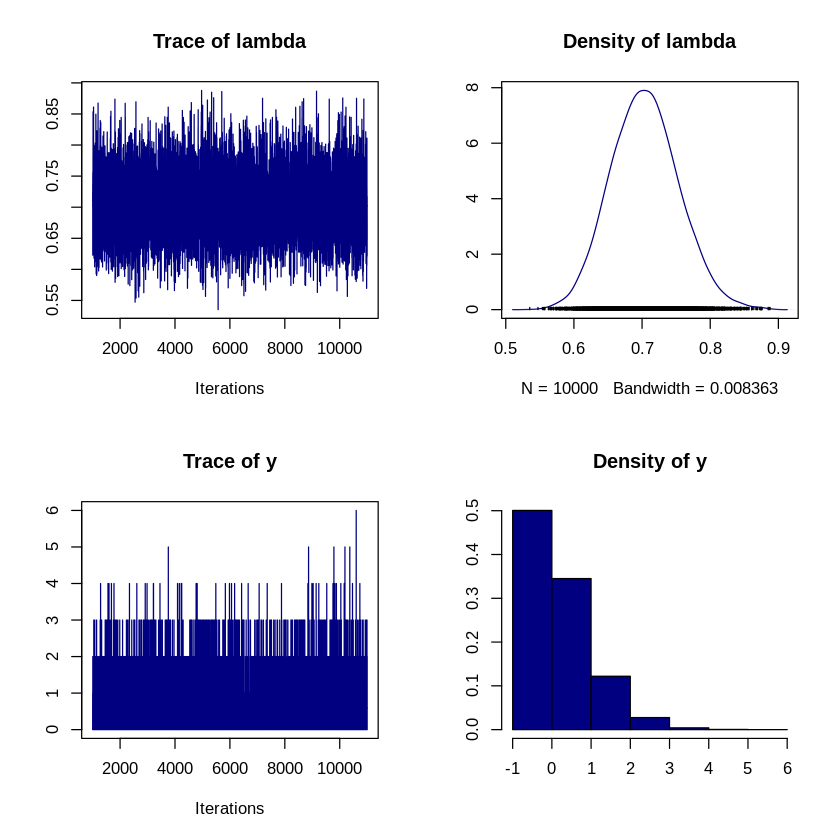

In [13]:
plot(chain2 , col="navy")
# Let ’s format our chain
chain2.df <- as.data.frame( as.mcmc(chain2) )
cat( sprintf ("\n Correlation matrix: \n"))
print(cor(chain2.df))

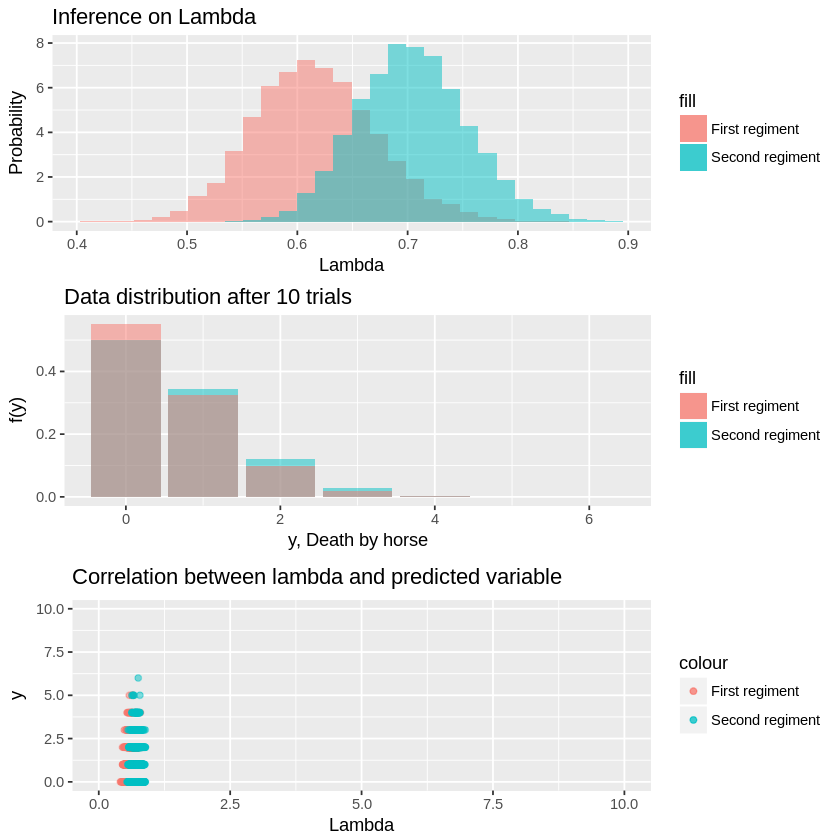

In [14]:
p1=ggplot()+
geom_histogram(data=chain1.df, aes(lambda, y = ..density.., fill='First regiment'),bins = 30, alpha=0.5)+
geom_histogram(data=chain2.df, aes(lambda, y = ..density.., fill='Second regiment'),bins = 30, alpha=0.5)+
labs(x='Lambda', y='Probability', title='Inference on Lambda')

ty1 <- table(chain1.df$y)
dt1 = data.frame(x=as.vector(0:(length(ty1)-1)), y=as.vector(ty1/sum(ty1)) )

ty2 <- table(chain2.df$y)
dt2 = data.frame(x=as.vector(0:(length(ty2)-1)), y=as.vector(ty2/sum(ty2)) )

p2=ggplot()+
geom_bar(data=dt2, aes(x=x, y=y, fill='Second regiment'),stat="identity", alpha=0.5)+
geom_bar(data=dt1, aes(x=x, y=y, fill='First regiment'),stat="identity", alpha=0.5)+
labs(x = 'y, Death by horse', y='f(y)', title='Data distribution after 10 trials')

p3=ggplot()+
geom_point(data=chain1.df, aes(x=lambda, y=y, color='First regiment'), alpha=0.5)+
geom_point(data=chain2.df, aes(x=lambda, y=y, color='Second regiment'), alpha=0.5)+
labs(x='Lambda', y='y', title='Correlation between lambda and predicted variable')+
ylim(0,10)+xlim(0,10)

grid.arrange(grobs=list(p1, p2, p3), nrow=3)

## Jeffrey Prior

In [15]:
obs = c(0, 1, 2, 3, 4, 5)
n1 = c(109, 65, 22, 3, 1, 0)
n2 = c(144, 91, 32, 11, 2, 0)



data1=c()
for (i in seq(1,length(obs)-1)){
    for (j in 1:n1[i]){
        data1 = c(data1, obs[i])
    }
}

data2=c()
for (i in seq(1,length(obs)-1)){
    for (j in 1:n2[i]){
        data2 = c(data2, obs[i])
    }
}

Data1 <- NULL
Data1$X <- data1 # Set of observations
Data1$n_next <- 10 # Predictions

Data2 <- NULL
Data2$X <- data2 # Set of observations
# data$n <- length(X) # those to be considered
Data2$n_next <- 10 # Predictions

In [16]:
model = 's11_inf_p_pred_jef.bug'

In [17]:
jm1 <- jags.model(model , Data1)
jm2 <- jags.model(model , Data2)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 2
   Total graph size: 204

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 280
   Unobserved stochastic nodes: 2
   Total graph size: 284

Initializing model



In [18]:
cat('Chain for the First Regiment')
update(jm1 , 1000)
chain1 <- coda.samples (jm1 , c("lambda", "y"), n.iter=10000)
print( summary (chain1 ))


cat('\n \n Chain for the Second Regiment')
update(jm2 , 1000)
chain2 <- coda.samples (jm2 , c("lambda", "y"), n.iter=10000)
print( summary (chain2 ))

Chain for the First Regiment
Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean      SD  Naive SE Time-series SE
lambda 0.6100 0.05557 0.0005557      0.0005586
y      0.6175 0.78387 0.0078387      0.0078387

2. Quantiles for each variable:

         2.5%    25%    50%    75%  97.5%
lambda 0.5056 0.5722 0.6082 0.6462 0.7234
y      0.0000 0.0000 0.0000 1.0000 2.0000


 
 Chain for the Second Regiment
Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean      SD  Naive SE Time-series SE
lambda 0.7001 0.04959 0.0004959      0.0004959
y      0.6917 0.83302 0.0083302      0.0084762

2. Quantiles for each variable:

         2.5%    25%    50%    75%  97.5%
lambda 0.6066 0.6656 0

First Regiment 

 Correlation matrix: 
           lambda          y
lambda 1.00000000 0.06239738
y      0.06239738 1.00000000


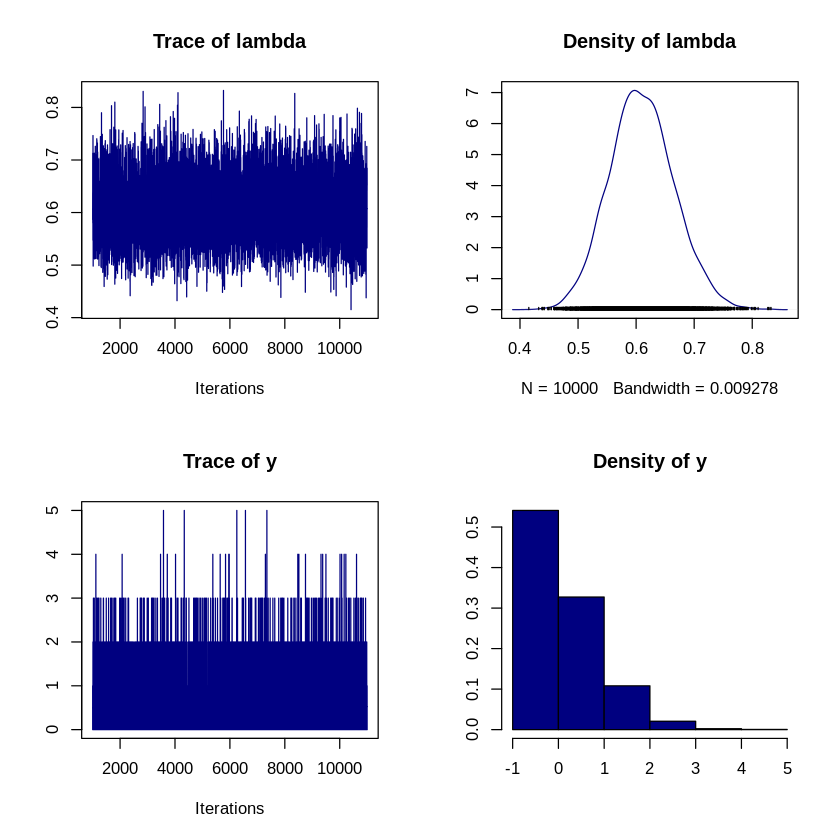

In [22]:
plot(chain1 , col="navy")
# Let ’s format our chain
chain1.df <- as.data.frame( as.mcmc(chain1) )
cat('First Regiment \n')
cat( sprintf ("\n Correlation matrix: \n"))
print(cor(chain1.df))

Second Regiment 

 Correlation matrix: 
           lambda          y
lambda 1.00000000 0.04257645
y      0.04257645 1.00000000


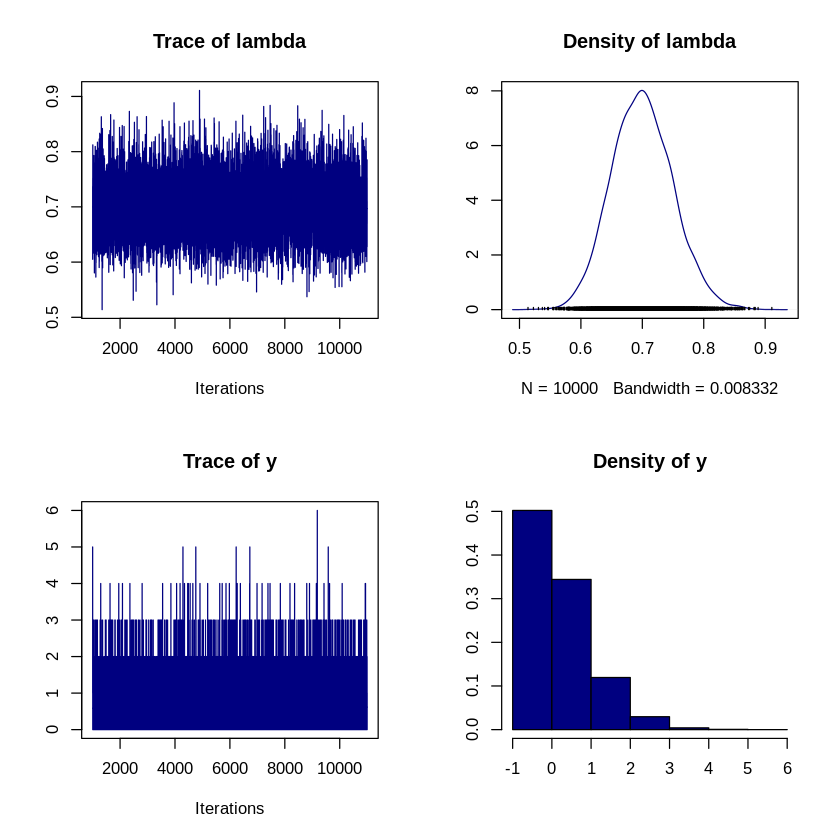

In [23]:
plot(chain2 , col="navy")
# Let ’s format our chain
chain2.df <- as.data.frame( as.mcmc(chain2) )
cat('Second Regiment \n')
cat( sprintf ("\n Correlation matrix: \n"))
print(cor(chain2.df))

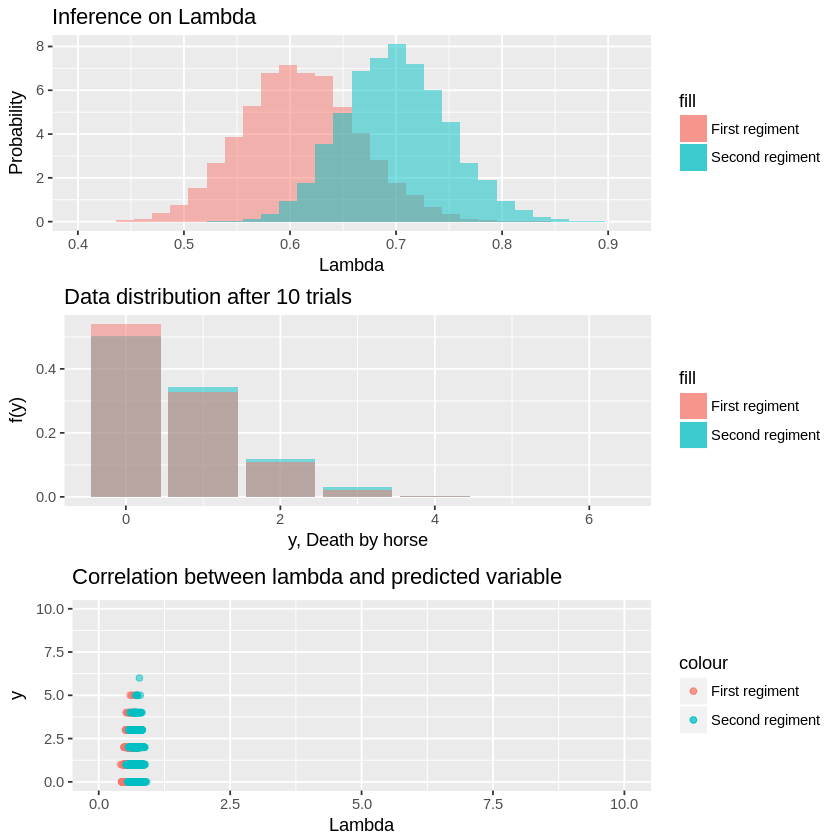

In [21]:
p1=ggplot()+
geom_histogram(data=chain1.df, aes(lambda, y = ..density.., fill='First regiment'),bins = 30, alpha=0.5)+
geom_histogram(data=chain2.df, aes(lambda, y = ..density.., fill='Second regiment'),bins = 30, alpha=0.5)+
labs(x='Lambda', y='Probability', title='Inference on Lambda')

ty1 <- table(chain1.df$y)
dt1 = data.frame(x=as.vector(0:(length(ty1)-1)), y=as.vector(ty1/sum(ty1)) )

ty2 <- table(chain2.df$y)
dt2 = data.frame(x=as.vector(0:(length(ty2)-1)), y=as.vector(ty2/sum(ty2)) )

p2=ggplot()+
geom_bar(data=dt2, aes(x=x, y=y, fill='Second regiment'),stat="identity", alpha=0.5)+
geom_bar(data=dt1, aes(x=x, y=y, fill='First regiment'),stat="identity", alpha=0.5)+
labs(x = 'y, Death by horse', y='f(y)', title='Data distribution after 10 trials')

p3=ggplot()+
geom_point(data=chain1.df, aes(x=lambda, y=y, color='First regiment'), alpha=0.5)+
geom_point(data=chain2.df, aes(x=lambda, y=y, color='Second regiment'), alpha=0.5)+
labs(x='Lambda', y='y', title='Correlation between lambda and predicted variable')+
ylim(0,10)+xlim(0,10)

grid.arrange(grobs=list(p1, p2, p3), nrow=3)

# Exercise 3

• A study on water quality of streams, a high level of bacter X was defined as a level greater than 100
per 100 ml of stream water. n = 116 samples were taken from streams having a high environmental
impact on pandas. Out of these, y = 11 had a high bacter X level.
• indicating with p the probability that a sample of water taken from the stream has a high bacter
X level,

In [9]:
n = 116 
y = 11
dp=0.0001
p = seq(0,1, dp)

(a) find the frequentist estimator for p

In [10]:
p.freq = y/n
cat('Frequantist estimator for p: ', p.freq)

Frequantist estimator for p:  0.09482759

(b) using a Beta(1, 10) prior for p, calculate and posterior distribution P (p ∣
∣ y)

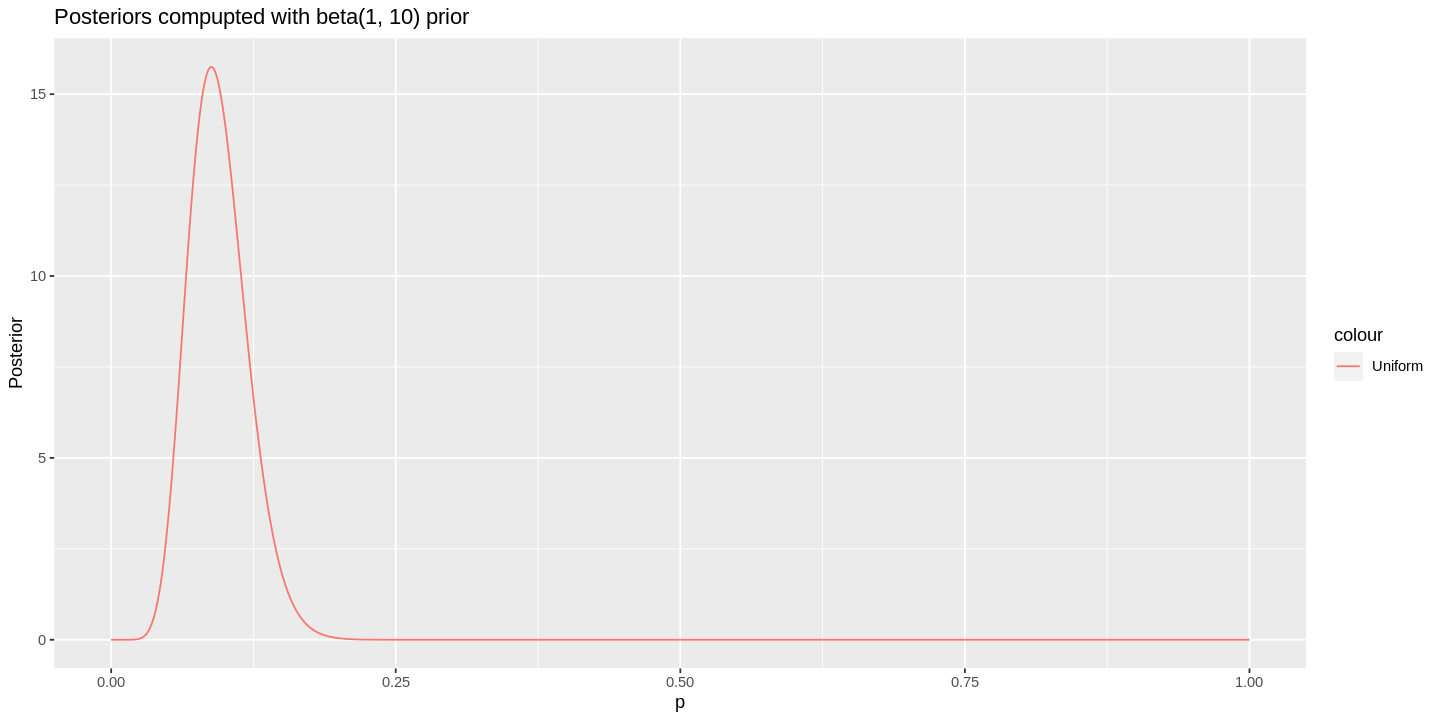

In [11]:
n_succ = y
n_trial = n
#Priors
prior.beta = function(p){g<-dbeta(p, 1, 10)
                     return (g)}

#likelihood
lhB = function(p){g <-dbinom(n_succ, n_trial, p)
                 return (g)}

#normalisation terms
norm.beta = integrate(function(x){lhB(x)*prior.beta(x)}, lower=0, upper=1)$value

#posterior
post.beta = function(p){i <- lhB(p)*prior.beta(p)/norm.beta
                   return (i)}
p.beta = post.beta(p)
p.beta[is.nan(p.beta)] = 0

ggplot(data=data.frame(p, p.beta), aes(x=p))+geom_line(aes(y=p.beta, color='Uniform'))+
                                                labs(title='Posteriors compupted with beta(1, 10) prior',
                                                      x='p',
                                                      y='Posterior')

(c) find the bayesian estimator for p, the posterior mean and variance, and a 95% credible interval

In [12]:
moment1.beta = integrate(function(x){x*post.beta(x)}, lower=0, upper=1)$value 
moment2.beta = integrate(function(x){(moment1.beta - x)*(moment1.beta - x)*post.beta(x)}, lower=0, upper=1)$value 

x.beta = ncredint(pvec=p, npost=p.beta,level=0.95,tol=0.01,verbose=FALSE)
beta = c(moment1.beta, moment2.beta, x.beta[['lower']], x.beta[['upper']])



df = data.frame(Beta = beta,
          row.names=c('First moment', 'Second moment', 'Lower limit (95% credibility)', 'Upper limit (95% credibility)'))
df

,Beta
,<dbl>
First moment,0.0944881890
Second moment,0.0006684388
Lower limit (95% credibility),0.0467000000
Upper limit (95% credibility),0.1459000000


(d) test the hypotesis
H◦ : p = 0.1 versus H1 : p ! = 0.1
at 5% level of significance with both the frequentist and bayesian approach

The closest we can get to alpha=0.05 is:  0.04761008 
The lower and upper limit to the 95% interval are: ( 5 ,  18 )
Since the number of successful events ( 11 ) fall whithin this range, we cannot reject the null hypotesis. 

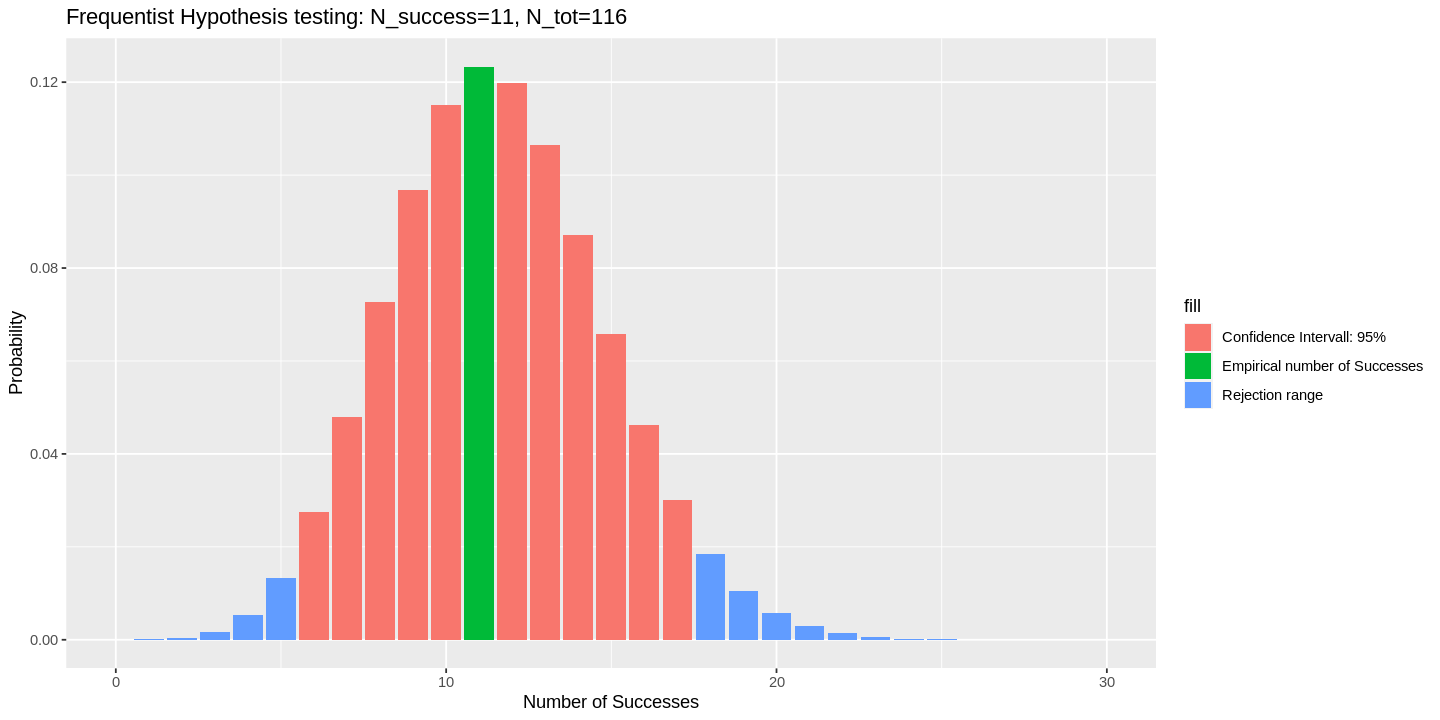

In [13]:
#Frequentist Approach
alpha = 0.05
p = seq(0,n,1)
p.freq = pbinom(p,n, prob=0.1, lower.tail = TRUE)

lower.limit = max(p[p.freq<=alpha/2])
upper.limit = min(p[p.freq>=1-alpha/2])

alpha.star = p.freq[lower.limit] + 1 - p.freq[upper.limit]
cat('The closest we can get to alpha=0.05 is: ', alpha.star, '\n')
cat('The lower and upper limit to the 95% interval are: (', lower.limit, ', ', upper.limit, ')\n')
cat('Since the number of successful events (', y, ') fall whithin this range, we cannot reject the null hypotesis. ')

ggplot()+
geom_col(aes(x=p, y=dbinom(p, n, 0.1), fill='Confidence Intervall: 95%'))+
geom_col(aes(x=p[p.freq<=alpha/2], y=dbinom(p[p.freq<=alpha/2], n, 0.1), fill='Rejection range'))+
geom_col(aes(x=p[p.freq>=1-alpha/2], y=dbinom(p[p.freq>=1-alpha/2], n, 0.1), fill='Rejection range'))+
geom_col(aes(x=y, y=dbinom(y, n, 0.1), fill='Empirical number of Successes'))+
xlim(0, 30)+
labs(x='Number of Successes', y = 'Probability', title='Frequentist Hypothesis testing: N_success=11, N_tot=116')

In [14]:
#Bayesian approach
cat('Since p=0.1 fall whithin the 95% crediility intervall of the posterior (',x.beta[['lower']],',',x.beta[['upper']],') we accept the null hypothesis.')

Since p=0.1 fall whithin the 95% crediility intervall of the posterior ( 0.0467 , 0.1459 ) we accept the null hypothesis.

• a new measurement, performed one month later on n = 165 water samples, gives y = 9 high bacter
X level

In [15]:
n2 = 165
y2 = 9

(e) find the frequentist estimator for p

In [16]:
p.freq.new = y2/n2
cat('p =', p.freq.new)

p = 0.05454545

(f) find a bayesian estimator for p, assuming both a Beta(1, 10) prior for p, and assuming the posterior
probability of the older measurement as the prior for the new one.

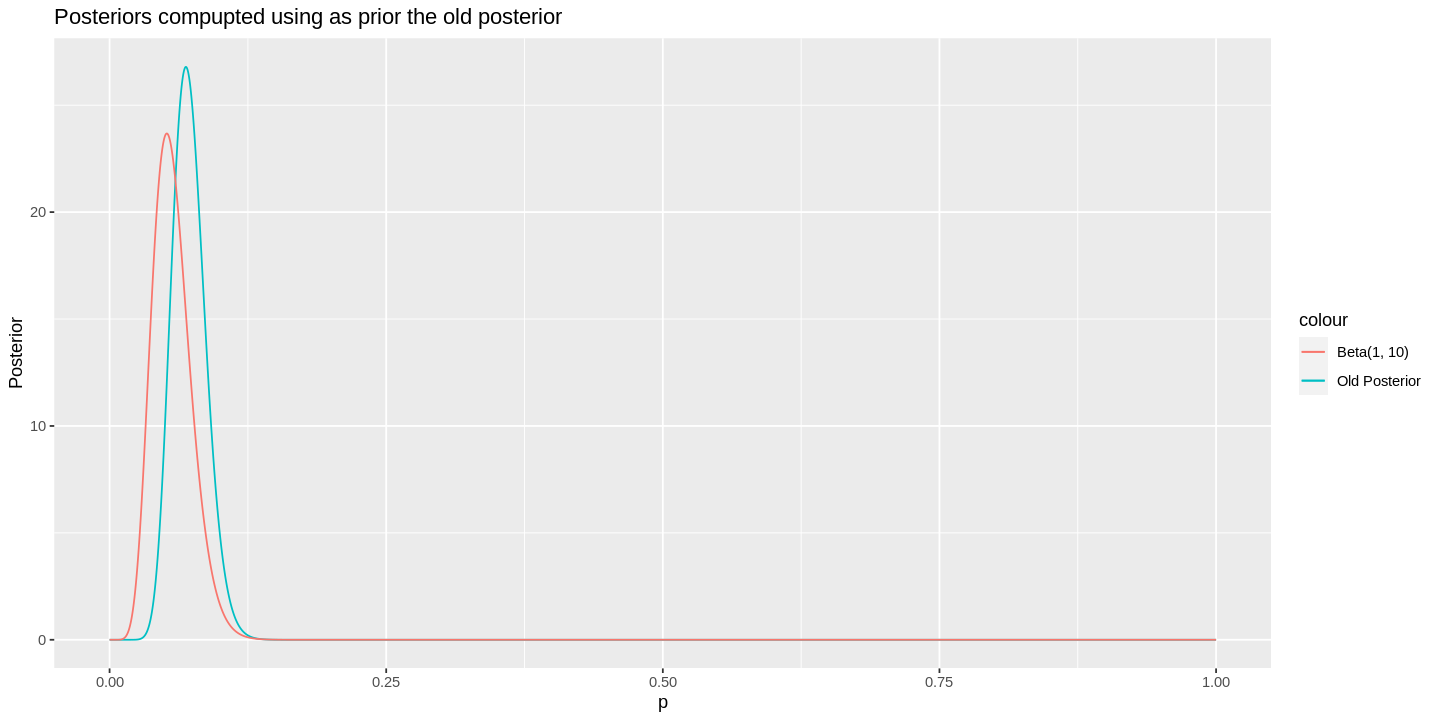

In [17]:
p = seq(0,1, dp)
n_succ2 = y2
n_trial2 = n2
#Priors
prior.beta.f = function(p){g<-dbeta(p, 1, 10)
                     return (g)}

#likelihood
lhB.f = function(p){g <-dbinom(n_succ2, n_trial2, p)
                 return (g)}

#normalisation terms
norm.beta.f = integrate(function(x){lhB.f(x)*prior.beta.f(x)}, lower=0, upper=1)$value

#posterior
post.beta.f = function(p){i <- lhB.f(p)*prior.beta.f(p)/norm.beta.f
                   return (i)}
p.beta.f = post.beta.f(p)
p.beta.f[is.nan(p.beta.f)] = 0


# # Old posterior as prior
#Priors
prior.old.mes = function(p){g<-post.beta(p)
                     return (g)}


#likelihood
lhB.new = function(p){g <-dbinom(n_succ2, n_trial2, p)
                 return (g)}

#normalisation terms
norm.new = integrate(function(x){lhB.new(x)*prior.old.mes(x)}, lower=0, upper=1)$value
#posterior
post.new = function(p){i <- lhB.new(p)*prior.old.mes(p)/norm.new
                   return (i)}
p.new = post.new(p)
p.new[is.nan(p.new)] = 0

ggplot(data=data.frame(p, p.new, p.beta.f), aes(x=p))+geom_line(aes(y=p.new, color='Old Posterior'))+geom_line(aes(y=p.beta.f, color='Beta(1, 10)'))+
                                                labs(title='Posteriors compupted using as prior the old posterior',
                                                      x='p',
                                                      y='Posterior')

(g) find the bayesian estimator for p, the posterior mean and variance, and a 95% credible interval

In [18]:
moment1.beta.f = integrate(function(x){x*post.beta.f(x)}, lower=0, upper=1)$value 
moment2.beta.f = integrate(function(x){(moment1.beta.f - x)*(moment1.beta.f - x)*post.beta.f(x)}, lower=0, upper=1)$value 

x.beta.f = ncredint(pvec=p, npost=p.beta.f,level=0.95,tol=0.01,verbose=FALSE)
beta.f = c(moment1.beta.f, moment2.beta.f, x.beta.f[['lower']], x.beta.f[['upper']])


moment1.new = integrate(function(x){x*post.new(x)}, lower=0, upper=1)$value 
moment2.new = integrate(function(x){(moment1.new - x)*(moment1.new - x)*post.new(x)}, lower=0, upper=1)$value 

x.new = ncredint(pvec=p, npost=p.new,level=0.95,tol=0.01,verbose=FALSE)
new = c(moment1.new, moment2.new, x.new[['lower']], x.new[['upper']])



df = data.frame(OldPost = new, Beta = beta.f,
          row.names=c('First moment', 'Second moment', 'Lower limit (95% credibility)', 'Upper limit (95% credibility)'))
df

,OldPost,Beta
,<dbl>,<dbl>
First moment,0.0719178082,0.0568181818
Second moment,0.0002278008,0.0003027677
Lower limit (95% credibility),0.0436000000,0.0251000000
Upper limit (95% credibility),0.1019000000,0.0914000000


(h) test the hypotesis

H◦ : p = 0.1 versus H1 : p 6 = 0.1
at 5% level of significance with both the frequentist and bayesian approach

The closest we can get to alpha=0.05 is:  0.04532508 
The lower and upper limit to the 95% interval are: ( 8 ,  24 )
Since the number of successful events ( 11 ) fall whithin this range, we cannot reject the null hypotesis. 
Note that the measurement barely fall inside the confidence intervall. 

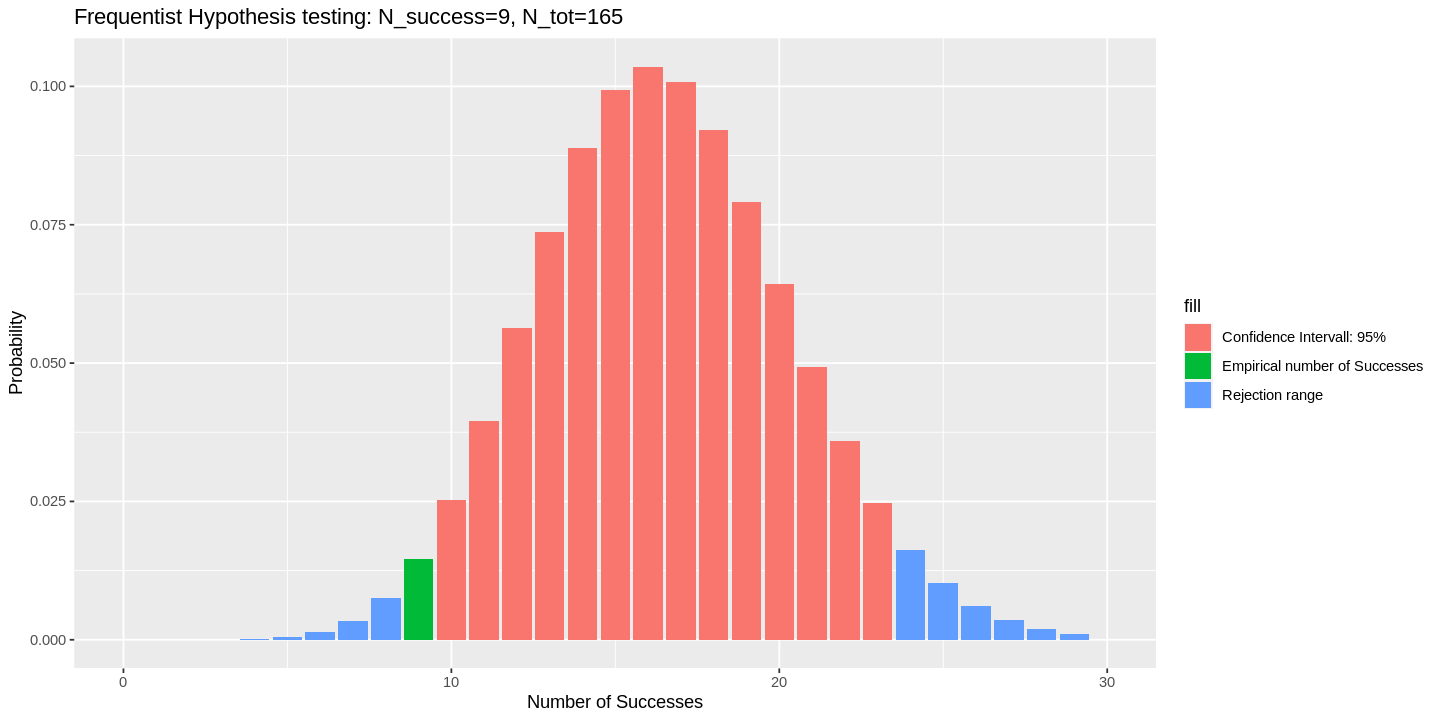

In [19]:
#Frequentist Approach
alpha = 0.05
p = seq(0,n2,1)
p.freq = pbinom(p,n2, prob=0.1, lower.tail = TRUE)

lower.limit = max(p[p.freq<=alpha/2])
upper.limit = min(p[p.freq>=1-alpha/2])

alpha.star = p.freq[lower.limit] + 1 - p.freq[upper.limit]
cat('The closest we can get to alpha=0.05 is: ', alpha.star, '\n')
cat('The lower and upper limit to the 95% interval are: (', lower.limit, ', ', upper.limit, ')\n')
cat('Since the number of successful events (', y, ') fall whithin this range, we cannot reject the null hypotesis. \n')
cat('Note that the measurement barely fall inside the confidence intervall. ')

ggplot()+
geom_col(aes(x=p, y=dbinom(p, n2, 0.1), fill='Confidence Intervall: 95%'))+
geom_col(aes(x=p[p.freq<=alpha/2], y=dbinom(p[p.freq<=alpha/2], n2, 0.1), fill='Rejection range'))+
geom_col(aes(x=p[p.freq>=1-alpha/2], y=dbinom(p[p.freq>=1-alpha/2], n2, 0.1), fill='Rejection range'))+
geom_col(aes(x=y2, y=dbinom(y2, n2, 0.1), fill='Empirical number of Successes'))+
xlim(0, 30)+
labs(x='Number of Successes', y = 'Probability', title='Frequentist Hypothesis testing: N_success=9, N_tot=165')

In [20]:
#Bayesian approach
cat('Using the old posterior as a prior:\n')
cat('since p=0.1 fall whithin the 95% crediility intervall of the posterior (',x.new[['lower']],',',x.new[['upper']],') we accept the null hypothesis.')


cat('\nUsing the beta(1,10) as a prior:\n')
cat('since p=0.1 doesnt fall whithin the 95% crediility intervall of the posterior (',
    x.beta.f[['lower']],
    ',',
    x.beta.f[['upper']],
    ') we reject the null hypothesis.')

Using the old posterior as a prior:
since p=0.1 fall whithin the 95% crediility intervall of the posterior ( 0.0436 , 0.1019 ) we accept the null hypothesis.
Using the beta(1,10) as a prior:
since p=0.1 doesnt fall whithin the 95% crediility intervall of the posterior ( 0.0251 , 0.0914 ) we reject the null hypothesis.

# Exercise 4

• analyze the data of Exercise 3 and solve points (b) and (c) using a MCMC with JAGS

In [24]:
n = 116
y = 11
obs = c(1, 0)
n_obs = c(y, n-y)


data=c()
for (i in seq(1,length(obs))){
    for (j in 1:n_obs[i]){
        data = c(data, obs[i])
    }
}


Data <- NULL
Data$X <- data # Set of observations
Data$n_next <- 10 # Predictions

In [25]:
model = 's11_inf_p_pred_binom.bug'

In [26]:
jm <- jags.model(model , Data)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 116
   Unobserved stochastic nodes: 2
   Total graph size: 121

Initializing model



In [27]:
update(jm , 1000)
chain <- coda.samples (jm , c("p", "y"), n.iter=10000)
print( summary (chain ))



Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

    Mean      SD  Naive SE Time-series SE
p 0.0948 0.02601 0.0002601      0.0002601
y 0.9464 0.96655 0.0096655      0.0098011

2. Quantiles for each variable:

     2.5%     25%     50%    75% 97.5%
p 0.05015 0.07633 0.09249 0.1108 0.152
y 0.00000 0.00000 1.00000 1.0000 3.000




 Correlation matrix: 
          p         y
p 1.0000000 0.2483448
y 0.2483448 1.0000000


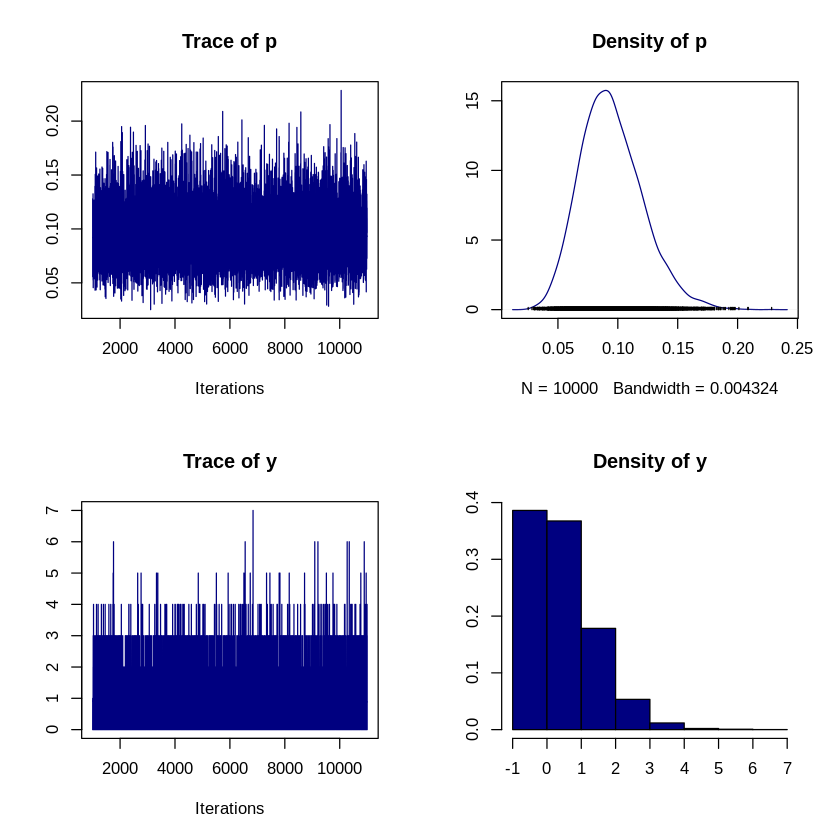

In [28]:
plot(chain , col="navy")
# Let ’s format our chain
chain.df <- as.data.frame( as.mcmc(chain) )
cat( sprintf ("\n Correlation matrix: \n"))
print(cor(chain.df))

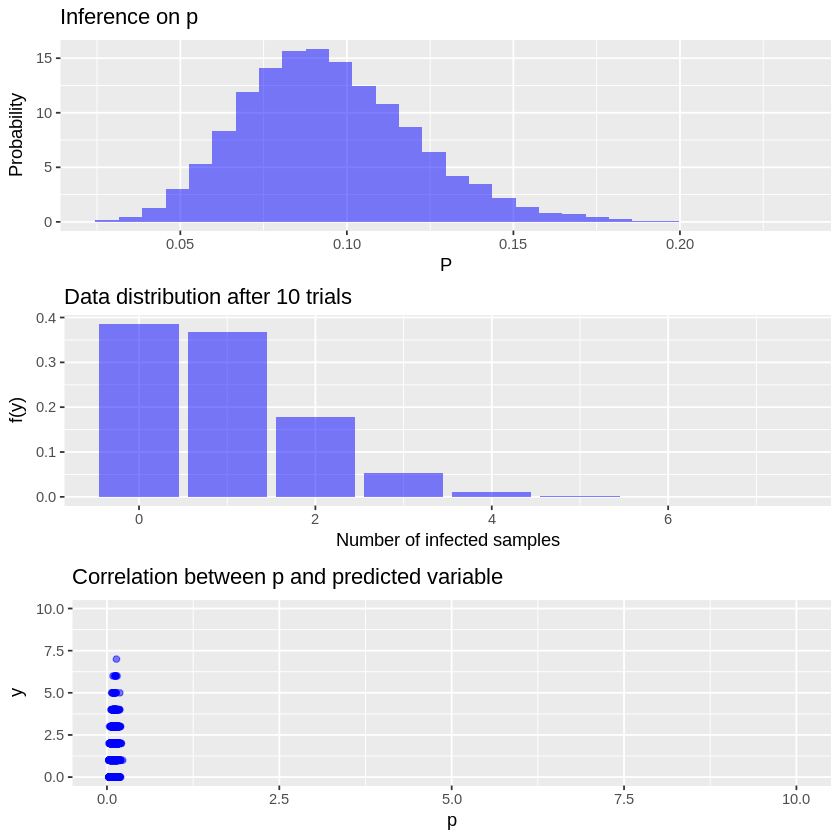

In [29]:
p1=ggplot()+
geom_histogram(data=chain.df, aes(p, y = ..density..),fill = 'blue',bins = 30, alpha=0.5)+
labs(x='P', y='Probability', title='Inference on p')

ty <- table(chain.df$y)
dt = data.frame(x=as.vector(0:(length(ty)-1)), y=as.vector(ty/sum(ty)) )

p2=ggplot()+
geom_bar(data=dt, aes(x=x, y=y),fill = 'blue',stat="identity", alpha=0.5)+
labs(x = 'Number of infected samples', y='f(y)', title='Data distribution after 10 trials')

p3=ggplot()+
geom_point(data=chain.df, aes(x=p, y=y),color = 'blue', alpha=0.5)+
labs(x='p', y='y', title='Correlation between p and predicted variable')+
ylim(0,10)+xlim(0,10)

grid.arrange(grobs=list(p1, p2, p3), nrow=3)